In [119]:
import math, matplotlib.pyplot as plt, torch, operator
from functools import partial

In [120]:
torch.set_printoptions(precision=3, linewidth=140, sci_mode=False)

# Create data

In [121]:
n_clusters = 6
n_samples = 250

In [122]:
centroids = torch.rand(n_clusters, 2)*70-35 

```torch.rand``` returns numbers sampled from a uniform distribution on interval ```[0,1)```. In this case, 2 values for each of the 6 clusters is sampled as the x,y coordinate of the centroids. The tensor is scaled by a factor of 70, which changes range of coordinates to ```[0,70)```. Then, it is shifted by 35 units, which changes its range again to ```[-35,35)```. 

In [123]:
torch.rand(3,2)

tensor([[0.309, 0.878],
        [0.703, 0.692],
        [0.741, 0.603]])

Now, we sample from a multivariate normal distribution for the x,y coordinates of the 250 samples in each cluster. Choose to sample from this distribution because it produces points that form circular/elliptical clusters centered around the mean, simulating natural clusters. 

In [124]:
from torch.distributions.multivariate_normal import MultivariateNormal
from torch import tensor 

In [125]:
torch.diag(tensor([5.,5.]))

tensor([[5., 0.],
        [0., 5.]])

In [126]:
centroids

tensor([[ 13.593, -15.559],
        [ 33.204, -14.728],
        [ 19.668,  17.967],
        [ -1.743,   0.992],
        [  0.926,  19.380],
        [ -8.055, -19.312]])

In [127]:
MultivariateNormal(centroids[0], torch.diag(tensor([5.,5.]))).sample((n_samples,))[:5]

tensor([[ 14.110, -16.305],
        [  7.865, -16.544],
        [ 13.164, -16.175],
        [ 10.847, -19.293],
        [ 16.322, -17.037]])

Using covariance matrix of zero off-diagonal means there is no correlation between x and y, and (in this case) each dimension is spread out with a std. dev. = $\sqrt{5} \approx 2.24$

In [128]:
def sample(c): 
    return MultivariateNormal(c, torch.diag(tensor([5.,5.]))).sample((n_samples,))

In [129]:
slices = [sample(c) for c in centroids]

In [130]:
len(slices)

6

In [131]:
data = torch.cat(slices)
data.shape

torch.Size([1500, 2])

In [132]:
def plot_data(centroids, data, ax=None):
    if ax is None: _,ax = plt.subplots()
    for i,centroid in enumerate(centroids):
        c = data[i*n_samples:(i+1)*n_samples]
        ax.scatter(c[:,0], c[:,1], s=1)
        ax.plot(*centroid, markersize=10, marker="x", color='k', mew=5)
        ax.plot(*centroid, markersize=5, marker="x", color='m', mew=2)

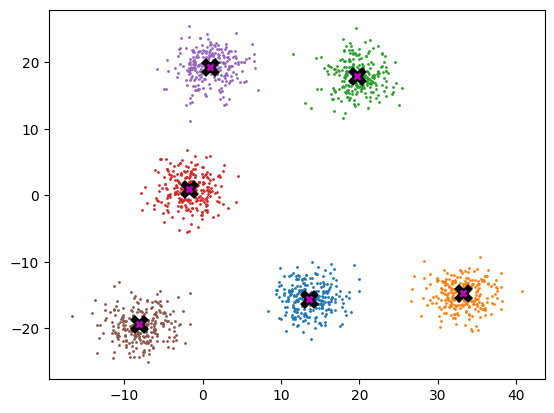

In [133]:
plot_data(centroids, data)

# Mean shift clustering algorithm

This algorithm doesn't require you to select the number of clusters ahead of time and can handle clusters of any shape. This is in contrast to kmeans, which requires selection of number of clusters and can only handle circular clusters. 

The algorithm is as follows:
1. For each point in ```data```, its **distance (d)** from every other point in the dataset is computed. 
2. Create weights for each point in ```data``` using the **Gaussian kernel** of its **distance** from the current datapoint of interest (```x```). 
    * Can be pictured as putting a gaussian window around ```x```, controlled by the **bandwith** which is the std.dev. of the Gaussian.
    * Penalizes points that are further away from ```x``` by driving its weight to 0. Essentially, you're finding neighbors within the bandwidth.
    * Rate at which weights fall to 0 is determined by bandwidth -- larger bandwidth (SD) = larger window = fewer zero weights --> larger, smoother clusters.
3. Update coordinates of ```x``` as the **weighted average** of all the points in the ```data``` using weight computed in (2).

Ultimately, this will push points that are close together even closer until they are right next to each other. Those that converge to the ~same final position (within a small threshold) belong to the same cluster. 

### Gaussian kernel

Here is the gaussian kernel formula:

In [136]:
def gaussian(d,bw):
    return torch.exp(-0.5*((d/bw)**2)) / (bw*math.sqrt(2*math.pi))

In [137]:
def plot_func(f):
    x = torch.linspace(0,10,100)
    plt.plot(x,f(x))

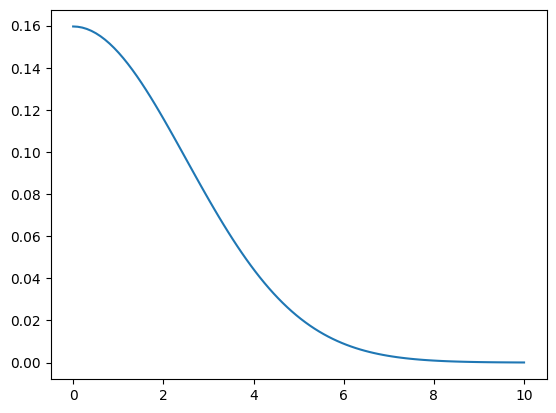

In [138]:
plot_func(partial(gaussian, bw=2.5))

### Writing the algorithm

Let's start by writing the algorithm for 1 single data point:

In [139]:
X = data.clone()
x = data[0]

In [140]:
x

tensor([ 12.074, -17.093])

In [141]:
x.shape, X.shape

(torch.Size([2]), torch.Size([1500, 2]))

Start with computing the distance of ```x``` from all points in ```X```. 

```x``` will automatically broadcast to match size of ```X``` since first dim matches (note: to meet broadcasting rules, all dims (from right to left) except broadcasting dim must match). 

In [142]:
print((X-x).shape)
(X-x)[:8]

torch.Size([1500, 2])


tensor([[ 0.000,  0.000],
        [ 4.017,  1.101],
        [ 2.813,  1.898],
        [ 1.581, -0.359],
        [ 0.406,  3.465],
        [ 0.119,  0.052],
        [ 0.831,  2.950],
        [ 6.068, -0.321]])

We need to calculate the distance of each point from every other point using L2 norm:

In [143]:
((X-x)**2).sum(1).sqrt().shape

torch.Size([1500])

We can also use **Einstein summation** to achieve this computation:

In [144]:
diff = X-x

In [145]:
diff.shape

torch.Size([1500, 2])

In [146]:
%time torch.einsum("ik,ik -> i", diff, diff)

CPU times: user 160 µs, sys: 0 ns, total: 160 µs
Wall time: 167 µs


tensor([  0.000,  17.351,  11.518,  ..., 444.472, 445.912, 438.941])

In [147]:
%time ((X-x)**2).sum(1)

CPU times: user 194 µs, sys: 17 µs, total: 211 µs
Wall time: 178 µs


tensor([  0.000,  17.351,  11.518,  ..., 444.472, 445.912, 438.941])

Faster using ```torch.einsum```!

In [148]:
dist = torch.einsum("ik,ik->i", diff, diff).sqrt()

In [149]:
dist.shape

torch.Size([1500])

Now, calculate weight for each data points using the **Gaussian kernel**:

In [150]:
weights = gaussian(dist, bw=2.5)

In [151]:
weights.shape, X.shape

(torch.Size([1500]), torch.Size([1500, 2]))

Now, the weighted average of all the data points. The dims don't match from right to left, so have to add a dim before we do the operation:

In [152]:
weights[:,None]*X

tensor([[     1.927,     -2.728],
        [     0.641,     -0.637],
        [     0.945,     -0.965],
        ...,
        [    -0.000,     -0.000],
        [    -0.000,     -0.000],
        [    -0.000,     -0.000]])

In [153]:
(weights[:,None]*X).sum(0)

tensor([ 228.695, -287.576])

In [154]:
((weights[:,None]*X).sum(0)) / weights.sum()

tensor([ 12.882, -16.199])

This is the updated coordinate of ```x```! This algorithm is repeated until convergence (points stop moving).

### Putting it all together

In [155]:
def one_update(X, bw=2.5):
    for i,x in enumerate(X):
        diff = X-x
        dist = torch.einsum("ik,ik->i", diff, diff).sqrt()
        weights = gaussian(dist, bw)
        X[i] = ((weights[:,None]*X).sum(0)) / weights.sum()

In [156]:
def meanshift(data):
    X = data.clone()
    for it in range(5):
        one_update(X)
    return X

In [157]:
%time X_ms = meanshift(data)

CPU times: user 1.65 s, sys: 357 µs, total: 1.65 s
Wall time: 1.65 s


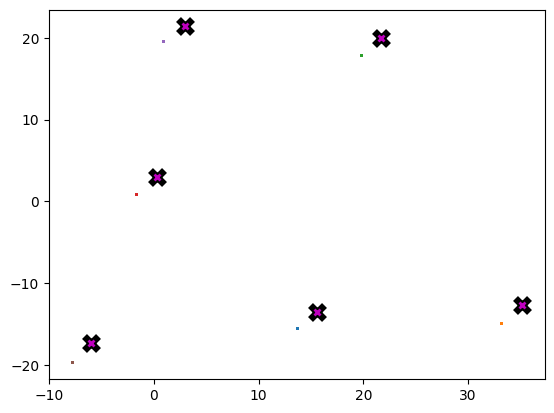

In [158]:
plot_data(centroids+2, X_ms) # displace the centroid a little to see that all data in same cluster ended up on top of e/o

# Animation

Animate the iterations of the algorithm so we can visualize all the intermediate steps 

In [159]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
%matplotlib inline

In [160]:
def do_one(d):
    if d: one_update(X)
    ax.clear()
    plot_data(centroids+2, X, ax=ax)

In [161]:
X = data.clone()
fig,ax = plt.subplots()
ani = FuncAnimation(fig, do_one, frames=5, interval=500, repeat=False)
plt.close()
HTML(ani.to_jshtml())

# GPU batched algorithm

We can make things go even faster if we can run it on the GPU.

In [162]:
bs=5
X = data.clone()
x = X[:bs]
X.shape, x.shape

(torch.Size([1500, 2]), torch.Size([5, 2]))

Have to add some new dims to make these compatible:

In [163]:
X[None].shape, x[:, None].shape

(torch.Size([1, 1500, 2]), torch.Size([5, 1, 2]))

In [164]:
diff = X[None] - x[:,None]
diff.shape

torch.Size([5, 1500, 2])

In [165]:
(torch.einsum("ijk,ijk->ij", diff, diff)).sqrt().shape

torch.Size([5, 1500])

In [166]:
# def dist_gpu(m): return (torch.einsum("ijk,ijk->ij", m, m)).sqrt()

def dist_gpu(full,batch): return ((full[None] - batch[:,None])**2).sum(2).sqrt() # this is faster on the gpu

In [167]:
weight_gpu = gaussian(dist_gpu(X,x), bw=2.5)
weight_gpu.shape

torch.Size([5, 1500])

In [168]:
X[None].shape, weight_gpu[...,None].shape

(torch.Size([1, 1500, 2]), torch.Size([5, 1500, 1]))

In [169]:
weight_gpu.sum(1)[:,None].shape

torch.Size([5, 1])

In [170]:
(X[None]*weight_gpu[...,None]).sum(1) / weight_gpu.sum(1)[:,None]

tensor([[ 12.882, -16.199],
        [ 14.804, -15.716],
        [ 14.205, -15.367],
        [ 13.608, -16.356],
        [ 13.019, -14.632]])

If we do this using ```einsum```:

In [171]:
torch.einsum("ik,kj->ij", weight_gpu, X) / weight_gpu.sum(1)[:,None]

tensor([[ 12.882, -16.199],
        [ 14.804, -15.716],
        [ 14.205, -15.367],
        [ 13.608, -16.356],
        [ 13.019, -14.632]])

The ```weight_gpu * X``` is actually just a simple matrix multiplication, so we can just do this:

In [172]:
weight_gpu@X / weight_gpu.sum(1)[:,None]

tensor([[ 12.882, -16.199],
        [ 14.804, -15.716],
        [ 14.205, -15.367],
        [ 13.608, -16.356],
        [ 13.019, -14.632]])

In [173]:
def meanshift(data, bs=500):
    n = len(data)
    X = data.clone()
    for it in range(5):
        for i in range(0, n, bs):
            s = slice(i, min(i+bs, n))
            # x = X[s]
            # diff = X[None] - x[:,None]
            weight_gpu = gaussian(dist_gpu(X, X[s]), bw=2.5)
            X[s] = weight_gpu@X / weight_gpu.sum(1)[:,None]
    return X

In [174]:
data = data.cuda()

In [175]:
X = meanshift(data).cpu()

In [176]:
%timeit -n 5 _=meanshift(data,bs=500).cpu()

4.16 ms ± 316 µs per loop (mean ± std. dev. of 7 runs, 5 loops each)


Much faster!

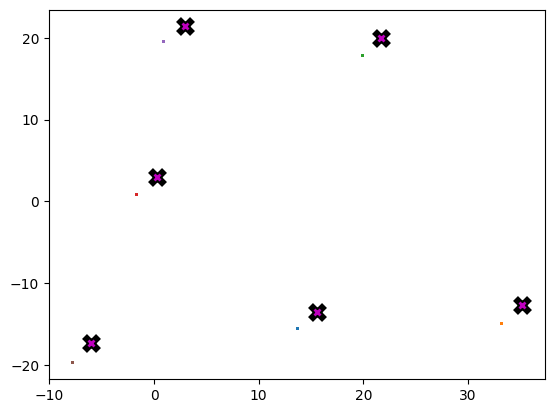

In [177]:
plot_data(centroids+2, X)